# Data Munging

In [1]:
import pandas as pd
import numpy as np

# header=0 doens't work, header=None simply inserts intergers as column names
df_raw = pd.read_csv(r"./ticdata2000.txt", sep='\t', header=None, low_memory=False)
df_test = pd.read_csv(r"./ticeval2000.txt", sep='\t', header=None, low_memory=False)

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [3]:
### DEPRECATED BY THE FOLLOWING CELL ###

# def get_item_description(start_row, end_row, from_nth_field_onward):
#     """
#     RETURN: A list of extracted item names
#     start_row: Starting row number of dictionary.txt
#     end_row: Ending row number of dictionary.txt
#     from_nth_field_onward: Take out a n-th field, delimited by space, and further to the right
#     """
    
#     # Thought of returning a ndarray but a "DeprecationWarning: 
#     #  "using a non-integer array as obj in delete will result in an error in the future"
#     import subprocess
    
#     unix_shell_command = 'awk \'NR>={0}&&NR<={1}\' "./dictionary.txt" | cut -d\  -f{2}- '.format(start_row, end_row, from_nth_field_onward)
    
#     headers = subprocess.check_output(unix_shell_command, shell=True)
    
#     #headers = subprocess.check_output('awk \'NR>=' + str(start_row) + '&&NR<=' + str(end_row) + '\' "./dictionary.txt" | cut -d\  -f3- ', shell=True)
#     #headers = subprocess.check_output('awk \'NR>=4&&NR<=89\' "./dictionary.txt" | cut -d\  -f3- ', shell=True)
#     # awk \'NR>=4&&NR<=89\' "./dictionary.txt" => take lines between 4 and 89, both incluive
#     #  (NOTE: escape character of "\" before ')
#     # cut -d\  -f3- => delimiter of a single space with escape character of "\" and
#     #  taking in the 3rd field onwards until end of the line
#     # This returns byte string e.g., b'Customer Subtype see L0\nNumber of...'

#     # Alternative to 'subprocess.check_output' is as follows:
#     # import os
#     # os.system("command")

#     header_list = "".join(map(chr, headers)).split('\n')
#     # "".join(map(chr, headers)) => convert bytes to a string
#     # .split('\n') => put the produced string into a list delimited by a line feed

#     header_list.pop()
#     # Unfortuantely this leaves a zero-string list item at the very end i.e., (''), so take it out

#     return header_list

In [4]:
def collect_data(keyword, first_item_number, from_nth_field):
    """
    RETURN: A list of items in data file
    first_item_number: Either 0 or 1, by which a first item is numbered
    from_nth_field: The number on and which field to the end of line to extract, delimited by a single space ' '
    """

    path_and_file_name_of_dictionary = "./dictionary.txt" # In relation to this ipynb file
    item_list = []
    
    section_found = False
    item_found = False
    end_of_info = False

    # Without "encoding="ISO-8859-1", non-printbale character spits "UnicodeDecodeError: 'utf-8' codec can't decode..."
    with open (path_and_file_name_of_dictionary, 'rt', encoding="ISO-8859-1") as myfile:
        for a_line in myfile:
            if (not end_of_info):
                if (not section_found) and (a_line[:len(keyword)] == keyword):
                    section_found = True
                elif section_found and (a_line[0]== str(first_item_number) or item_found):
                    if a_line == '\n':
                        end_of_info = True
                    else:
                        item_name = ''
                        field_list = a_line.split()

                        for idx in range(from_nth_field - 1, len(field_list)):
                            item_name = item_name + ' ' + field_list[idx]

                        item_list.append(item_name[1:len(item_name)])
                        item_found = True
            else:
                return item_list
    return item_list # When reaching end of file, this line gets executed for 'L4'

In [5]:
def fetch_list_item(nd_array, keyword, from_nth_index = 0):
    """
    RETURN: A tuple of matched item AND index number 
    Fetch column name according to the passed-in 'keyword'
    Perform "exact" search to see if string match AT the end of string ONLY
    """
    
    for index, item in enumerate(nd_array):
        if index >= from_nth_index:
            if item[-len(keyword):] == keyword:
                return index, item
    return None

In [6]:
def remove_duplicate(df_series, dictionary, offset):
    """
    RETURN: A list without a duplicate
    df_series: A DataFrame Series, i.e., one-column DataFrame
    dictionary: A list of items in the look-up dictionary
    offset: Either 0 or 1, by which to offset raw data numbers as the dicionary is always 0-based
    """
    
    # Create a ndarray from a DataFrame column
    nd_array_data = df_series.to_numpy()
    
    # DEBUG np.savetxt(r"./test_start.txt", nd_array_data)
    
    duplicate_items = []
    
    for index, item in enumerate(dictionary):
        if dictionary.count(item) > 1:
            res =  fetch_list_item(dictionary, item, index+1)
            if res is not None:
            # Locate the index of the OTHER duplicate, to be kept and aligned, from the beginning of the list
                duplicate_num, _ = res

                duplicate_items.append([index, duplicate_num])
    
    # Finally take out the duplicates        
    for dup in duplicate_items:
        dictionary.pop(dup[0]) 
        
        # The subsequent items of the found duplicate must be pushed forward by subtracting 1, to have it aligned with dictionary.txt
        nd_array_data = np.where(nd_array_data>dup[0], nd_array_data - 1, nd_array_data)
        
        # Now replace the duplicate index with the OTHER index of its identical entry
        nd_array_data[np.where(nd_array_data==dup[0])] = dup[1]

    # Adjust raw data numbers where its corresponding column/field in the dectionary list has 1-based order
    nd_array_data = nd_array_data - offset
    
    return dictionary, nd_array_data

In [12]:
def change_column_type_from_int64_to_category():
    """
    Format DataFrame by replacing 'pure' indices in dictionary.txt with meaningful descriptions
    """
    dictionary_label_prefix = 'L'
    
    data_tables = [[0, 1, 2], 
                     [1, 1, 2], 
                     [2, 1, 2], 
                     [3, 0, 2], 
                     [4, 0, 2]]
    # 1st element: A number - prefixed with 'L' - whose table in the dictionary.txt describes further e.g., L0, L1, and L2
    # 2nd element: N-based index in the dictionary.txt. Where it's 1 
    #              we subtract 1 from the original data to make it zero(0)-based, so as to suit indexes of category type
    # 3rd element: The number of n-th field in each line to be taken    

    def remove_duplicate_and_assign_new_values(df, item):
        label_list, new_values = remove_duplicate(df[item], 
                                                collect_data(dictionary_label_prefix + str(i[0]), i[1], i[2]),
                                                i[1])
            
        df[item] = new_values
    
    for i in data_tables:
        res = fetch_list_item(list_of_column_names,
                              dictionary_label_prefix + str(i[0]),
                              0)
        if res is not None:
            index, item = res
            
            remove_duplicate_and_assign_new_values(df_raw, item)
            remove_duplicate_and_assign_new_values(df_test, item)
            #label_list, new_values = remove_duplicate(df_raw[item], 
            #                                                    collect_data(dictionary_label_prefix + str(i[0]), i[1], i[2]),
            #                                                    i[1])
            
            
            #df_raw[item] = new_values
            
            ###
            # The following fails to convert string to categorical variables
            ###
            #df_raw[item] = df_raw[item].astype('category').cat.as_ordered()
            #
            #df_raw[item] = pd.CategoricalIndex(df_raw[item].map(dict(enumerate(label_list))),
            #                                     ordered=True, 
            #                                     categories=label_list)
            

In [8]:
column_names = [["DATA DICTIONARY", 1, 3]]
list_of_column_names = collect_data(str(column_names[0][0]), column_names[0][1], column_names[0][2])

df_raw.columns = list_of_column_names
df_test.columns = list_of_column_names[:-1] # Take out the last column 'Number of mobile home policies 0 - 1' as NOT included

In [15]:
df_raw.head()

,Customer Subtype see L0,Number of houses 1  10,Avg size household 1  6,Avg age see L1,Customer main type see L2,Roman catholic see L3,Protestant ...,Other religion,No religion,Married,...,Number of private accident insurance policies,Number of family accidents insurance policies,Number of disability insurance policies,Number of fire policies,Number of surfboard policies,Number of boat policies,Number of bicycle policies,Number of property insurance policies,Number of social security insurance policies,Number of mobile home policies 0 - 1
0,29,1,3,1,7,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,33,1,2,1,7,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,33,1,2,1,7,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,5,1,3,2,2,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,36,1,4,1,9,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


In [13]:
#dummy_column_name = "dummy"

#df_test[dummy_column_name] = 0

change_column_type_from_int64_to_category()

#df_test.drop(df_test.columns[df_test.shape[1]-1], axis='columns')

#df_test.drop(dummy_column_name, axis='columns')


In [16]:
df_raw.head()

,Customer Subtype see L0,Number of houses 1  10,Avg size household 1  6,Avg age see L1,Customer main type see L2,Roman catholic see L3,Protestant ...,Other religion,No religion,Married,...,Number of private accident insurance policies,Number of family accidents insurance policies,Number of disability insurance policies,Number of fire policies,Number of surfboard policies,Number of boat policies,Number of bicycle policies,Number of property insurance policies,Number of social security insurance policies,Number of mobile home policies 0 - 1
0,29,1,3,1,7,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,33,1,2,1,7,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,33,1,2,1,7,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,5,1,3,2,2,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,36,1,4,1,9,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


In [17]:
df_raw.to_feather('formatted_raw_data')

# Data Exploring

In [18]:
df_raw = pd.read_feather('formatted_raw_data')

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

Good benchmark to extract validation set out of training set is 20% according to Fast.ai's Jeremy Howard. Thus, train_size is set to **0.8** below. Also take a look at this descerning article (https://www.fast.ai/2017/11/13/validation-sets/).

The sample is NOT a timeseries data and thus cross-validation can be a good candidate as well as out-of-bag hyperparameter in Random Forest.

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

# Separate into 2 DataFrames:
#  1. Target/Dependent value (Attribute 86, "CARAVAN:Number of mobile home policies") and 
#  2. Features

# Tuple is zero-based, but columns is one-based
col_idx = df_raw.shape[1]-1

df_target = df_raw.iloc[:, col_idx]
df_features = df_raw.drop(df_raw.columns[col_idx], axis='columns')

# Use train_test_split to create train and validation set instead of test set, which we already have
# Random seed is of course '42' due to 'The Hitchhiker's Guide to the Galaxy'!
X_train, X_valid, y_train, y_valid = train_test_split(df_features, df_target, train_size=0.8, shuffle=False) # random_state=42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

/home/to/miniconda3/envs/caravan/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((4657, 85), (1165, 85), (4657,), (1165,))

In [21]:
num_decision_trees = 100 # Take a default value of Python 3.7

clf = RandomForestClassifier(n_estimators = num_decision_trees, n_jobs = -1)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9922697015245866

In [22]:
clf.predict_proba(X_valid)

array([[0.82888889, 0.17111111],
       [0.995     , 0.005     ],
       [0.9425    , 0.0575    ],
       ...,
       [0.99      , 0.01      ],
       [1.        , 0.        ],
       [0.925     , 0.075     ]])

First column represents the model's calculation for probablity of zero (0), whereas second does one (1).

In [24]:
# Build a confusion matrix: correctly predicted ones are diagonally displayed
def build_confusion_matrix(clf, df_features, df_target):
    df = pd.crosstab(df_target, clf.predict(df_features), rownames=['Actuals'], colnames=['Predicteds'])
    print (df)
    count_correct_incorrect_total(df)
    

In [30]:
def count_correct_incorrect_total(df):
    correct_sum = 0
    total_sum = 0
    
    num_classes = len(df.index)    
    
    for i in range(num_classes):
        for j in range(num_classes):
            total_sum += df.loc[i, j]
            if i == j:
                correct_sum += df.loc[i, j]

    print ("\nCorrect: {0:,}, Incorrect: {1:,}, Total: {2:,} => Accuracy: {3:.4f}%".format(correct_sum, 
                                                                                   total_sum - correct_sum, 
                                                                                   total_sum,
                                                                                   correct_sum / total_sum * 100))

In [31]:
build_confusion_matrix(clf, X_valid, y_valid)

Predicteds     0   1
Actuals             
0           1078  10
1             73   4

Correct: 1,082, Incorrect: 83, Total: 1,165 => Accuracy: 92.8755%


In [45]:
X_test = pd.read_csv(r"./ticeval2000.txt", sep='\t', header=None, low_memory=False)

y_test = pd.read_csv(r"./tictgts2000.txt", sep='\t', header=None, low_memory=False)
# At this point, type(y_test) is pandas.core.frame.DataFrame, which is NOT appropriate input for RandomForestClassifer
# y_test.shape  = (4000, 1)

y_test = y_test.iloc[:, 0]
# This above converts to pandas.core.series.Series
# y_test.shape  = (4000,)
# ':' creates a 'deep' copy

clf.predict_proba(X_test)

array([[0.97625   , 0.02375   ],
       [0.77241667, 0.22758333],
       [0.94      , 0.06      ],
       ...,
       [0.955     , 0.045     ],
       [0.95325   , 0.04675   ],
       [0.91458333, 0.08541667]])

In [47]:
build_confusion_matrix(clf, X_test, y_test)

Predicteds     0   1
Actuals             
0           3727  35
1            232   6

Correct: 3,733, Incorrect: 267, Total: 4,000 => Accuracy: 93.3250%


I will stop right here to discuss perhaps the **most** salient process of data scienece.

# Feature Engineering vs. Hyperparameter Tuning

I was so eager to get hyperparmerter tuning right from the very beginning and fell prey to this fallacy.

Take a look at this article for a moment: https://towardsdatascience.com/why-you-should-do-feature-engineering-first-hyperparameter-tuning-second-as-a-data-scientist-334be5eb276c

&emsp;"You should focus more on getting good features (Feature Engineering) instead of optimizing your model’s hyperparameters (Hyperparameter Tuning). You see… If you don’t have good features that the model can learn from, it will not improve your model’s performance even though you have the optimum hyperparameter,”

&emsp;"... your model will not be able to learn the underlying “pattern” if the data isn’t representative enough to describe the problem that you’re trying to solve. And this is where the role of feature engineering comes into play."

&emsp;"having a strong business domain knowledge will let you understand more about the data that you have and generate new features based on its relevance and relationship."

&emsp;"Hyperparameters are crucial as they control the overall behaviour of a machine learning model. The ultimate goal is to find an optimal combination of hyperparameters that minimizes a predefined loss function to give better results."

In [23]:
preds = clf.predict(X_valid)

In [63]:
predictions = np.stack([t.predict(X_valid) for t in clf.estimators_])
predictions[:,1000], np.mean(predictions[:,1000])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 0.0)

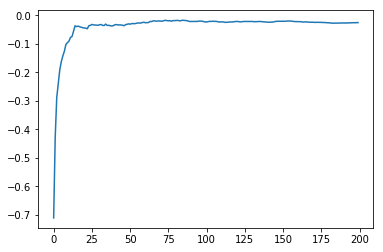

In [64]:
plt.plot([metrics.r2_score(y_valid, np.mean(predictions[:i+1], axis=0)) for i in range(num_decision_trees)]);

In [ ]:
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [36]:
df = pd.DataFrame({'customer' : [2, 0, 1]})
df

,customer
0,2
1,0
2,1


In [37]:
label_names = ['Single', 'Married', 'Widowed']
label_names

['Single', 'Married', 'Widowed']

In [39]:
df['customer'] = pd.CategoricalIndex(df['customer'].map(dict(enumerate(label_names))),
                                     ordered=True, 
                                     categories=label_names)
#df['customer'] = label_names
df['customer'] = df['customer'].astype('category')
df

,customer
0,Widowed
1,Single
2,Married


In [40]:
df.columns

Index(['customer'], dtype='object')

In [41]:
df['customer'].cat.categories

Index(['Single', 'Married', 'Widowed'], dtype='object')

In [42]:
df['customer'].cat.codes

0    2
1    0
2    1
dtype: int8

In [43]:
df['customer'].ftype

'category:dense'

In [44]:
df['customer'].dtype

CategoricalDtype(categories=['Single', 'Married', 'Widowed'], ordered=True)

In [45]:
df

,customer
0,Widowed
1,Single
2,Married


# Hyperparameter tuning GRID SEARCH!